<a href="https://colab.research.google.com/github/yumehara/atmacup11/blob/main/notebooks/EfficientNet_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q timm

     |████████████████████████████████| 378kB 25.5MB/s 


In [9]:
!pip install -q pytorch_lightning

     |████████████████████████████████| 819kB 35.6MB/s 
     |████████████████████████████████| 829kB 46.7MB/s 
     |████████████████████████████████| 122kB 51.0MB/s 
     |████████████████████████████████| 235kB 41.6MB/s 
     |████████████████████████████████| 645kB 40.8MB/s 
     |████████████████████████████████| 10.6MB 43.3MB/s 
     |████████████████████████████████| 1.3MB 29.4MB/s 
     |████████████████████████████████| 143kB 52.2MB/s 
     |████████████████████████████████| 296kB 51.1MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.


In [32]:
!pip install wandb

In [29]:
import os
import sys
from collections import OrderedDict

# Third Parties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import time

# PyTorch
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.optimizer import Optimizer
from torch.utils import data

# torchvision
from torchvision import transforms as T
from torchvision.models import resnet34
import timm

# pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

# scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def get_path(filename):
    return os.path.join('/content/drive/MyDrive/atmacup11', filename)

In [27]:
input_dir = get_path("inputs")
dataset_root = input_dir
photo_dir = get_path("inputs/photos")

output_path = get_path("outputs/submit_3")
os.makedirs(output_path, exist_ok=True)

In [11]:
# 定数たち
IS_DEBUG = False
N_SPLITS = 2 if IS_DEBUG else 4
MAX_EPOCHS = 3 if IS_DEBUG else 200
ES_PATIENCE = 25
RLR_PATIENCE = 7
RLR_FACTOR = 0.25
BATCH_SIZE = 64
NUM_WORKERS = 2

In [12]:
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

In [13]:
def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    return Image.open(to_img_path(object_id))

def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)

    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

### Dataset

In [14]:
class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    target_key = "target"

    @property
    def meta_keys(self):
        """"""
        retval = [self.object_path_key]

        if self.phase == 'train' or self.phase == 'valid':
            retval.append(self.target_key)

        return retval

    def __init__(self, meta_df: pd.DataFrame, phase='train', transform=None):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります

            phase:
                train のとき学習用のデータ拡張を適用します.
                train 以外の時は単に size にリサイズを行います

            transform:
                画像にかける変換処理
        """

        self.phase = phase
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError(f"meta_df must have {k}")

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")
        self.transform = transform

        size = (224, 224)

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, target = (data.get(self.object_path_key),
                            data.get(self.target_key, -1),)
        img = Image.open(obj_path)
        img = self.transform(img)

        if self.phase == 'test':
            return img

        return img, target

    def __len__(self):
        return len(self.meta_df)

### DataModule

In [15]:
class AtmaDataModule(pl.LightningDataModule):
    def __init__(self,
                 dataset_root: str = '../input',
                 batch_size: int = 32,
                 fold: int = 0,
                 num_workers: int = 20,):

        super().__init__()
        self.dataset_root = dataset_root
        self.batch_size = batch_size
        self.fold = fold
        self.num_workers=num_workers

    def get_test_df(self):
        return pd.read_csv(os.path.join(self.dataset_root, 'test.csv'))

    def split_train_valid_df(self):
        df = pd.read_csv(os.path.join(self.dataset_root, 'train.csv'))

        # Split
        kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
        for i, (train_idx, valid_idx) in enumerate(kf.split(df, y=df['target'])):
            df.loc[valid_idx, 'fold'] = int(i)
        df['fold'] = df['fold'].astype(int)

        train_df = df[df['fold'] != self.fold].reset_index(drop=True)
        valid_df = df[df['fold'] == self.fold].reset_index(drop=True)
        return train_df, valid_df

    def setup(self, stage=None):
        self.test_df = self.get_test_df()
        train_df, valid_df = self.split_train_valid_df()
        self.train_df = train_df
        self.valid_df = valid_df

    def get_dataframe(self, phase):
        assert phase in {'train', 'valid', 'test'}
        if phase == 'train':
            return self.train_df
        elif phase == "valid":
            return self.valid_df
        elif phase == "test":
            return self.test_df

    def get_transform(self, phase):
        IMG_MEAN = [0.485, 0.456, 0.406]
        IMG_STD = [0.229, 0.224, 0.225]
        size = (224, 224)

        additional_items = (
            [T.Resize(size)]
            if phase != 'train'
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
#                     saturation=[0.85, 1.15],
#                     hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size, scale=(0.15, 1.0)),
#                 T.Resize(size),
            ]
        )

        transform = T.Compose(
            [*additional_items, 
             T.ToTensor(), 
#              T.Normalize(mean=IMG_MEAN, std=IMG_STD),
            ])

        return transform

    def get_ds(self, phase):
        assert phase in {"train", "valid", "test"}
        ds = AtmaDataset(
            meta_df=create_metadata(self.get_dataframe(phase=phase)),
            transform=self.get_transform(phase=phase),
            phase=phase,
        )
        return ds

    def get_loader(self, phase):
        dataset = self.get_ds(phase=phase)

        return data.DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=True if phase == "train" else False,
            num_workers=self.num_workers,
            drop_last=True if phase == "train" else False,
        )

    def train_dataloader(self):
        return self.get_loader(phase='train')

    def val_dataloader(self):
        return self.get_loader(phase='valid')

    def predict_dataloader(self):
        return self.get_loader(phase='test')

### LightningModule

In [16]:
class LitModule(pl.LightningModule):

    def get_model(self):
        model = timm.create_model('efficientnet_b0', pretrained=False)
        model.classifier = self.eff_fc_layer()
        return model

    def eff_fc_layer(self):
        fc_list = [nn.Linear(in_features=1280, out_features=32, bias=True),
                   nn.Dropout(0.2),
                   nn.Linear(in_features=32, out_features=1, bias=True)]
        return nn.Sequential(*fc_list)

    def get_crit(self):
        return nn.MSELoss()

    def calculate_elapsed_time(self):
        elapsed_time = int(time.time() - self.start_time)
        elapsed_minute = (elapsed_time % 3600) / 60
        return elapsed_minute

    def __init__(self):
        super(LitModule, self).__init__()
        self.net = self.get_model()
        self.crit = self.get_crit()
        self.start_time = time.time()

    def forward(self, x):
        output = self.net(x).squeeze(1)
        return output

    def training_step(self, batch, batch_idx):
        imgs, targets = batch
        output = self(imgs)
        loss = self.crit(output, targets.float())
        return loss

    def training_epoch_end(self, outputs):
        train_epoch_loss = torch.stack([o["loss"] for o in outputs]).mean().item()
        self.log('train_loss', train_epoch_loss)
        print(f'train_epoch_loss : {train_epoch_loss}')

    def validation_step(self, batch, batch_idx):
        imgs, targets = batch
        preds = self(imgs)
        loss = self.crit(preds, targets.float())

        output = OrderedDict({
            "preds": preds.detach(),
            "targets": targets.detach(),
            "loss": loss.detach(),
        })
        return output

    def validation_epoch_end(self, outputs):
        d = dict()
        d["epoch"] = int(self.current_epoch)
        d["valid_loss"] = torch.stack([o["loss"] for o in outputs]).mean().item()

        preds = torch.cat([o["preds"].view(-1) for o in outputs]).cpu().numpy()
        targets = torch.cat([o["targets"].view(-1) for o in outputs]).cpu().numpy()

        mse_target = mean_squared_error(y_true=targets, y_pred=preds)
        d["valid_mse_target"] = mse_target

        d["elapsed_minute"] = self.calculate_elapsed_time()

        self.log_dict(d)
        print(d)

    def configure_optimizers(self):
        optimizer = Adam(self.net.parameters(), lr=5e-3)
        lr_scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, mode='min', factor=RLR_FACTOR, patience=RLR_PATIENCE),
            'monitor': 'valid_loss',
        }

        return [optimizer], [lr_scheduler]

In [17]:
class NotebookProgress(ProgressBarBase):

    def __init__(self):
        super().__init__()  # don't forget this :)
        self.enable = True

    def disable(self):
        self.enable = False

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        super().on_train_batch_end(trainer, pl_module, outputs, batch, batch_idx, dataloader_idx)  # don't forget this :)
        percent = (self.train_batch_idx / self.total_train_batches) * 100
        sys.stdout.flush()
        sys.stdout.write(f'{percent:.01f} percent complete \r')

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        super().on_validation_batch_end(trainer, pl_module, outputs, batch, batch_idx, dataloader_idx)# don't forget this :)

### Train

In [34]:
def train(cfg_name: str, output_path: str, fold: int,) -> None:
    seed_everything(42)

    logger = CSVLogger(save_dir=output_path, name=f"fold_{fold}")
    # wandb_logger = WandbLogger(name=f"{cfg_name}_{fold}", project='ore', offline=IS_DEBUG)

    # 学習済重みを保存するために必要
    checkpoint_callback = ModelCheckpoint(
        dirpath=str(output_path), filename=f"{cfg_name}_{fold}",
        save_weights_only=True,
        save_top_k=None,
        monitor='valid_mse_target',
    )

    early_stop_callback = EarlyStopping(
        monitor='valid_mse_target',
        min_delta=0.00,
        patience=ES_PATIENCE,
        verbose=False,
        mode='min'
    )

    progress = NotebookProgress()
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    trainer = Trainer(
        max_epochs=MAX_EPOCHS,
        gpus=1,
        callbacks=[checkpoint_callback, 
                   early_stop_callback,
                   progress,
                   lr_monitor,],
        logger=[logger],  # wandb_logger
        limit_train_batches=0.02 if IS_DEBUG else 1.0,
        limit_val_batches=0.05 if IS_DEBUG else 1.0,
    )

    model = LitModule()
    datamodule = AtmaDataModule(dataset_root=dataset_root,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS)
    trainer.fit(model, datamodule=datamodule)

    return checkpoint_callback.best_model_path, checkpoint_callback.best_model_score

In [35]:
best_model_paths = []

sum_mse = 0
for fold in tqdm(range(N_SPLITS)):
    best_model_path, best_model_score = train(cfg_name=f'pl_first', output_path=output_path, fold=fold)
    best_model_paths.append(best_model_path)

    sum_mse += best_model_score / N_SPLITS
    print(f'best_model_path : {best_model_path}')
    print(f'best_model_score : {best_model_score}')

# CVスコアを表示
print(sum_mse ** 0.5)


  0%|          | 0/4 [00:00<?, ?it/s]Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 4.0 M 
1 | crit | MSELoss      | 0     
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.194    Total estimated model params size (MB)
Global seed set to 42


{'epoch': 0, 'valid_loss': 3.7815473079681396, 'valid_mse_target': 3.7815475196567294, 'elapsed_minute': 0.5}
train_epoch_loss : 2.602890968322754
{'epoch': 0, 'valid_loss': 1.0968434810638428, 'valid_mse_target': 1.0931549360872825, 'elapsed_minute': 6.6}
train_epoch_loss : 0.9703523516654968
{'epoch': 1, 'valid_loss': 2.2195305824279785, 'valid_mse_target': 2.2629352703987986, 'elapsed_minute': 6.95}
train_epoch_loss : 0.9545039534568787
{'epoch': 2, 'valid_loss': 0.9905874729156494, 'valid_mse_target': 0.9899116369361307, 'elapsed_minute': 7.283333333333333}
train_epoch_loss : 0.9400492906570435
{'epoch': 3, 'valid_loss': 1.3839410543441772, 'valid_mse_target': 1.3568244222897334, 'elapsed_minute': 7.633333333333334}
train_epoch_loss : 0.9132664203643799
{'epoch': 4, 'valid_loss': 0.899712324142456, 'valid_mse_target': 0.8887988329894851, 'elapsed_minute': 7.966666666666667}
train_epoch_loss : 0.8928257822990417
{'epoch': 5, 'valid_loss': 1.0063097476959229, 'valid_mse_target': 1.00


 25%|██▌       | 1/4 [43:49<2:11:27, 2629.10s/it]Global seed set to 42


{'epoch': 106, 'valid_loss': 0.691528856754303, 'valid_mse_target': 0.694512289758584, 'elapsed_minute': 43.8}
best_model_path : /content/drive/MyDrive/atmacup11/outputs/submit_3/pl_first_0.ckpt
best_model_score : 0.6850059628486633


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 4.0 M 
1 | crit | MSELoss      | 0     
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.194    Total estimated model params size (MB)
Global seed set to 42


{'epoch': 0, 'valid_loss': 3.7815473079681396, 'valid_mse_target': 3.7815475196567294, 'elapsed_minute': 0.016666666666666666}
train_epoch_loss : 2.606931209564209
{'epoch': 0, 'valid_loss': 1.0447732210159302, 'valid_mse_target': 1.0425663522706468, 'elapsed_minute': 0.36666666666666664}
train_epoch_loss : 0.9629899859428406
{'epoch': 1, 'valid_loss': 7.051397323608398, 'valid_mse_target': 7.02336881058821, 'elapsed_minute': 0.7166666666666667}
train_epoch_loss : 0.9698377251625061
{'epoch': 2, 'valid_loss': 0.9437435865402222, 'valid_mse_target': 0.9376939413443178, 'elapsed_minute': 1.0666666666666667}
train_epoch_loss : 0.935206413269043
{'epoch': 3, 'valid_loss': 0.957021951675415, 'valid_mse_target': 0.9426295528488778, 'elapsed_minute': 1.4333333333333333}
train_epoch_loss : 0.9089121222496033
{'epoch': 4, 'valid_loss': 0.9076651334762573, 'valid_mse_target': 0.8957807204611523, 'elapsed_minute': 1.7833333333333334}
train_epoch_loss : 0.9050830602645874
{'epoch': 5, 'valid_loss'


 50%|█████     | 2/4 [1:26:57<1:27:13, 2616.80s/it]Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 4.0 M 
1 | crit | MSELoss      | 0     
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.194    Total estimated model params size (MB)


best_model_path : /content/drive/MyDrive/atmacup11/outputs/submit_3/pl_first_1.ckpt
best_model_score : 0.7023137211799622


Global seed set to 42


{'epoch': 0, 'valid_loss': 3.7815473079681396, 'valid_mse_target': 3.7815475196567294, 'elapsed_minute': 0.016666666666666666}
train_epoch_loss : 2.617267370223999
{'epoch': 0, 'valid_loss': 1.267066478729248, 'valid_mse_target': 1.2699628927624114, 'elapsed_minute': 0.36666666666666664}
train_epoch_loss : 1.0073933601379395
{'epoch': 1, 'valid_loss': 1.0139920711517334, 'valid_mse_target': 1.0092080508607522, 'elapsed_minute': 0.7333333333333333}
train_epoch_loss : 0.963072657585144
{'epoch': 2, 'valid_loss': 0.9637945294380188, 'valid_mse_target': 0.958914116202433, 'elapsed_minute': 1.1166666666666667}
train_epoch_loss : 0.9342101812362671
{'epoch': 3, 'valid_loss': 0.9128943085670471, 'valid_mse_target': 0.9000861387269107, 'elapsed_minute': 1.4666666666666666}
train_epoch_loss : 0.9063341021537781
{'epoch': 4, 'valid_loss': 0.8850617408752441, 'valid_mse_target': 0.874551245742645, 'elapsed_minute': 1.8166666666666667}
train_epoch_loss : 0.8891501426696777
{'epoch': 5, 'valid_loss


 75%|███████▌  | 3/4 [1:51:43<37:57, 2277.62s/it]  Global seed set to 42


{'epoch': 68, 'valid_loss': 0.7689095735549927, 'valid_mse_target': 0.7626794078268756, 'elapsed_minute': 24.75}
best_model_path : /content/drive/MyDrive/atmacup11/outputs/submit_3/pl_first_2.ckpt
best_model_score : 0.7391380667686462


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 4.0 M 
1 | crit | MSELoss      | 0     
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.194    Total estimated model params size (MB)
Global seed set to 42


{'epoch': 0, 'valid_loss': 3.7815473079681396, 'valid_mse_target': 3.7815475196567294, 'elapsed_minute': 0.016666666666666666}
train_epoch_loss : 2.609081983566284
{'epoch': 0, 'valid_loss': 14.701860427856445, 'valid_mse_target': 15.239756743363904, 'elapsed_minute': 0.36666666666666664}
train_epoch_loss : 0.9829149842262268
{'epoch': 1, 'valid_loss': 0.9826668500900269, 'valid_mse_target': 0.977521557457934, 'elapsed_minute': 0.7333333333333333}
train_epoch_loss : 0.9773586392402649
{'epoch': 2, 'valid_loss': 3.877246379852295, 'valid_mse_target': 3.9860944132116063, 'elapsed_minute': 1.1}
train_epoch_loss : 0.9493375420570374
{'epoch': 3, 'valid_loss': 1.0018067359924316, 'valid_mse_target': 0.996943894543313, 'elapsed_minute': 1.4833333333333334}
train_epoch_loss : 0.9264337420463562
{'epoch': 4, 'valid_loss': 0.9251118898391724, 'valid_mse_target': 0.9179055474362614, 'elapsed_minute': 1.8333333333333333}
train_epoch_loss : 0.9045239686965942
{'epoch': 5, 'valid_loss': 0.931284010


100%|██████████| 4/4 [2:34:03<00:00, 2310.95s/it]

best_model_path : /content/drive/MyDrive/atmacup11/outputs/submit_3/pl_first_3.ckpt
best_model_score : 0.6598560810089111
tensor(0.8346, device='cuda:0')


In [36]:
predictions = np.zeros(len(test_df))

for model_path in best_model_paths:
    model = LitModule.load_from_checkpoint(checkpoint_path=model_path)
    trainer = Trainer(gpus=1)

    datamodule = AtmaDataModule(dataset_root=dataset_root,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS)

    preds = trainer.predict(model, datamodule=datamodule, return_predictions=True)
    preds = torch.cat(preds)
    predictions += preds.cpu().numpy() / N_SPLITS

predictions

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


array([1.19715458, 1.83261013, 1.93595111, ..., 1.96761587, 1.73710319,
       0.41219832])

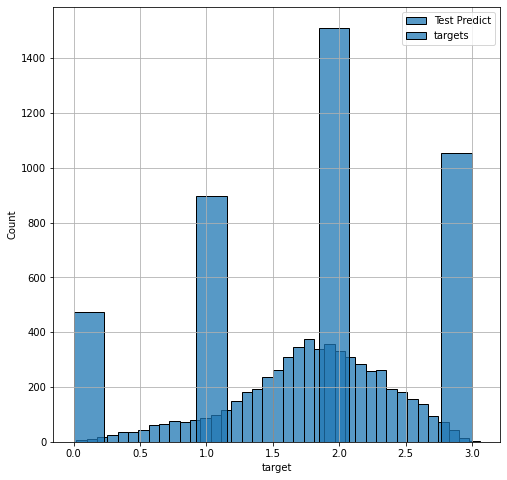

In [37]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(predictions, label='Test Predict')
sns.histplot(train_df['target'], label='targets')
ax.legend()
ax.grid()

In [38]:
sub_df = pd.read_csv(os.path.join(input_dir, 'atmaCup#11_sample_submission.csv'))
sub_df['target'] = predictions

sub_df.to_csv(os.path.join(output_path, 'submission_3.csv'), index=False)